In [25]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score


In [2]:
#year_list = np.arange(1993,2001,1) #1993-2000 as training & validation set
year_list = np.arange(2001,2020,1) #2001-2019 as test set
images = []
label_df = []
for year in tqdm(year_list):
    images.append(np.memmap(os.path.join("./monthly_20d",\
                                         f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r')
                   .reshape((-1, 64, 60)))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d",\
                                                 f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.28it/s]


(1403975, 64, 60)
(1403975, 35)


(-0.5, 59.5, 63.5, -0.5)

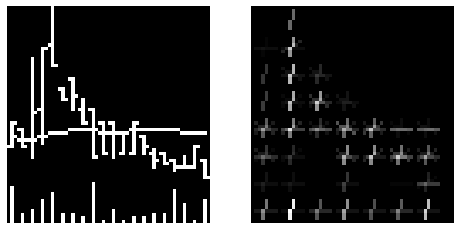

In [21]:
_, HOG_fig = hog(images[50,:,:], 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            block_norm = 'L1',
            visualize=True, 
            multichannel=False)
plt.figure(figsize = (8,16))

plt.subplot(121)
plt.imshow(images[50,:,:], cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(HOG_fig, cmap = 'gray')
plt.axis('off')


In [3]:
feature_hog = []
for i in tqdm(np.arange(np.shape(images)[0])):
    feature_hog.append(hog(images[i,:,:], 
                            orientations=9, 
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), 
                            block_norm = 'L1',
                            visualize=False, 
                            multichannel=False))
    
feature_hog = np.array(feature_hog)    

100%|██████████| 1403975/1403975 [19:28<00:00, 1201.44it/s]


In [ ]:
# Save the HOG feature vectors as npy files
# np.save('E:/Study/HKUST/2-Statistical Prediction/Final_Project_Image/HOG_feature_train.npy',feature_hog)
# np.save('E:/Study/HKUST/2-Statistical Prediction/Final_Project_Image/HOG_feature_test.npy',feature_hog)

## Training the model (Logistic Regression)

In [22]:
#%%
def get_metrics(labels, predict):
    print("Accuracy: ", accuracy_score(labels, predict))
    print("Precision: ", precision_score(labels, predict))
    print("Recall: ", recall_score(labels, predict))
    print("F1-score: ", f1_score(labels, predict))
    
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

In [23]:
# load in training data and remove samples with nan return
feature_hog = np.load('E:/Study/HKUST/2-Statistical Prediction/Final_Project_Image/models/HOG/HOG_feature_train.npy')
label_df = []
for year in tqdm(np.arange(1993,2001,1)):
    label_df.append(pd.read_feather(os.path.join("./monthly_20d",\
                                                 f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
label_df = pd.concat(label_df)
y = label_df['Retx_20d_label'].to_numpy()
label_value = label_df['Retx_20d'].to_numpy()
tmp = (np.isnan(y) | (y==2))
y = y[tmp==False]
label_value = label_value[tmp==False]
feature_hog = feature_hog[tmp==False, :]
print(np.shape(feature_hog), np.shape(y))
print(np.shape(label_value))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.72it/s]


(787028, 1512) (787028,)
(787028,)


In [24]:
X_train, X_val, y_train, y_val = train_test_split(feature_hog, y, test_size=0.3, random_state=0)
y_train_value, y_val_value = train_test_split(label_value, test_size=0.3, random_state=0)

In [26]:
# clf_LR = LogisticRegression(penalty = 'l2', random_state = 0, solver = 'sag', verbose = 1)
clf = SGDClassifier(loss = 'log', random_state = 0)
clf.fit(X_train, y_train)

SGDClassifier(loss='log', random_state=0)

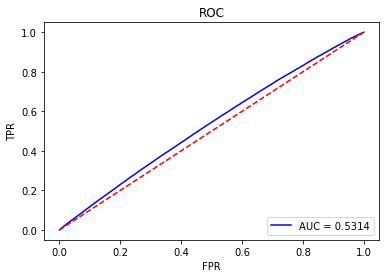

Accuracy:  0.525041400370168
Precision:  0.5152211372774268
Recall:  0.31401515814531517
F1-score:  0.3902078280823483
Correlation Spearman:  SpearmanrResult(correlation=0.06367967332872788, pvalue=1.2114390748292948e-210)
Correlation Pearson:  (0.042903125724301765, 1.3286264458155558e-96)
Val Loss:  tensor(0.6914)


In [27]:
from scipy import stats
import torch
import torch.nn

### Prediction result of Logistic Regression on validation set
y_proba = clf.predict_proba(X_val)[:,1]
y_pred = clf.predict(X_val)
y_proba_all = clf.predict_proba(X_val)

plot_roc(y_val, y_proba)
get_metrics(y_val, y_pred)
print("Correlation Spearman: ", stats.spearmanr(list(y_proba), list(y_val_value)))
print("Correlation Pearson: ", stats.pearsonr(list(y_proba), list(y_val_value)))
loss_fn = torch.nn.CrossEntropyLoss()
print("Val Loss: ", loss_fn(torch.Tensor(y_proba_all), torch.LongTensor(y_val)))

## Testing the model on the test set

In [32]:
# load in testing data and remove samples with nan return
X_test = np.load('E:/Study/HKUST/2-Statistical Prediction/Final_Project_Image/models/HOG/HOG_feature_test.npy')
y_test = []
for year in tqdm(np.arange(2001,2020,1)):
    y_test.append(pd.read_feather(os.path.join("./monthly_20d",\
                                                 f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
y_test = pd.concat(y_test)
y_test_value = y_test['Retx_20d'].to_numpy()
y_test = y_test['Retx_20d_label'].to_numpy()
tmp = (np.isnan(y_test) | (y_test==2))
print(np.shape(X_test), np.shape(y_test))
print(np.shape(y_test_value))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.35it/s]


(1403975, 1512) (1403975,)
(1403975,)


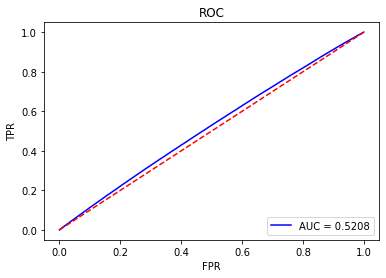

Accuracy:  0.5106646123005292
Precision:  0.5290393310542124
Recall:  0.34490055134127756
F1-score:  0.417570957996962
Correlation Spearman:  SpearmanrResult(correlation=0.03829517801259079, pvalue=0.0)
Correlation Pearson:  (0.022040105335876296, 2.127426257997058e-149)
Test Loss:  tensor(0.6929)


In [34]:
from scipy import stats
import torch
import torch.nn

### Prediction result of Logistic Regression on test set
y_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
y_proba_all = clf.predict_proba(X_test)

tmp = (np.isnan(y_test) | (y_test==2))
plot_roc(y_test[tmp==False], y_proba[tmp==False])
get_metrics(y_test[tmp==False], y_pred[tmp==False])
tmp = (np.isnan(y_test_value) | (y_test_value==2))
print("Correlation Spearman: ", stats.spearmanr(list(y_proba[tmp==False]), list(y_test_value[tmp==False])))
print("Correlation Pearson: ", stats.pearsonr(list(y_proba[tmp==False]), list(y_test_value[tmp==False])))
loss_fn = torch.nn.CrossEntropyLoss()
print("Test Loss: ", loss_fn(torch.Tensor(y_proba_all[tmp==False]), torch.LongTensor(y_test[tmp==False])))

In [37]:
X_test[0].shape

(1512,)